In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from utils import *
import re
import gensim
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import datetime
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from itertools import combinations
from joblib import dump, load
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import ruptures as rpt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/adamblock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/adamblock/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/adamblock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
CHANNELS = ['cnn', 'fox', 'msnbc']
NUM_TOPICS = 15

# Getting Words Associated to Topics

Moved to top to make it easier to access.  We load the NMF model and TFIDF vectorizer, and print out the top few words asssociated to each topic.

In [4]:
nmf = load("./models/NMF_all_"+ str(NUM_TOPICS) +"_topics.joblib")
tfidf_vectorizer = load("./models/tfidf_vectorizer.joblib")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [5]:
number_of_words = 5
display_topics(nmf, tfidf_feature_names,number_of_words)

Topic 0:
state world united threat nation
Topic 1:
gas greenhouse emission cut growing
Topic 2:
president obama house white paris
Topic 3:
everywhere touched pot impacted specie
Topic 4:
issue care health republican democrat
Topic 5:
believe science real republican human
Topic 6:
new deal york time green
Topic 7:
scientist sensor car tree network
Topic 8:
people american many young million
Topic 9:
trump donald hoax administration chinese
Topic 10:
tax carbon energy need clean
Topic 11:
know need mean whats thing
Topic 12:
country america environment facing mark
Topic 13:
year last ago weather temperature
Topic 14:
right he gore al youre


# 1) Getting and Preprocessing Data

In [6]:
PARENT = "../TelevisionNews/"

In [7]:
cnn, fox, msnbc = get_data(PARENT)

In [8]:
cnn["cleanSnip"] = cnn["Snippet"].apply(lambda x: preprocessing(x, stop_words,False))
fox["cleanSnip"] = fox["Snippet"].apply(lambda x: preprocessing(x, stop_words,False))
msnbc["cleanSnip"] = msnbc["Snippet"].apply(lambda x: preprocessing(x, stop_words,False))

In [9]:
all_shows = pd.concat([cnn,fox,msnbc])

# 2)  Model Selection with `gensim`

Making our data legible to `gensim`

In [34]:
corpus = list(all_shows["cleanSnip"])

In [35]:
dictionary = gensim.corpora.Dictionary(corpus)

In [36]:
common_corpus = [dictionary.doc2bow(text) for text in corpus]

## Training NMF models

In [37]:
topic_range = range(5,17)
nmf_models = []
for k in topic_range:
    print(f"Working on k = {k}")
    model = Nmf(common_corpus, num_topics=k, id2word=dictionary)
    nmf_models.append(model)

Working on k = 5
Working on k = 6
Working on k = 7
Working on k = 8
Working on k = 9
Working on k = 10
Working on k = 11
Working on k = 12
Working on k = 13
Working on k = 14
Working on k = 15
Working on k = 16


## Getting Coherences

In [38]:
coherence_models = []
coherences = []
for k in topic_range:
    print(f"Working on k = {k}")
    coherence_model = CoherenceModel(model=nmf_models[k -5], texts=all_shows["cleanSnip"], coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_models.append(coherence_model)
    coherences.append(coherence)
    

Working on k = 5
Working on k = 6
Working on k = 7
Working on k = 8
Working on k = 9
Working on k = 10
Working on k = 11
Working on k = 12
Working on k = 13
Working on k = 14
Working on k = 15
Working on k = 16


Now we plot the coherences and select the largest

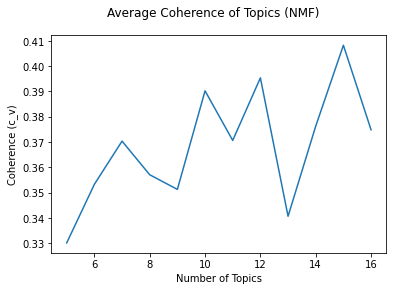

In [39]:
fig, ax = plt.subplots()
ax.plot(topic_range, coherences)
ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence (c_v)")
fig.suptitle("Average Coherence of Topics (NMF)")
fig.savefig("./plots/Coherences.png")
plt.show()


## Showing Topic words with `gensim`

Unnecessary now.  Can be used to display top few words associated with each topic from the NMF model in `gensim`

# 3) Topic Mentions over Time

We now switch to `sklearn` as these models better integrate with our other analysis.  First, we need a different format for `cleanSnip` to use in `sklearn`:

In [96]:
def topic_words(model, names, no_top_words=5):
    relevant_words = dict()
    for topic_idx, topic in enumerate(model.components_):
        relevant_words[topic_idx] = {names[i] for i in topic.argsort()[:-no_top_words - 1:-1]}
    return relevant_words


In [97]:
def display_topics(model, feature_names, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [44]:
cnn["cleanSnip"] = cnn["Snippet"].apply(lambda x: preprocessing(x, stop_words,True))
fox["cleanSnip"] = fox["Snippet"].apply(lambda x: preprocessing(x, stop_words,True))
msnbc["cleanSnip"] = msnbc["Snippet"].apply(lambda x: preprocessing(x, stop_words,True))
all_shows = pd.concat([cnn,fox,msnbc])

The cell below trains the TFIDF vectorizer on the data.  We have pretrained this, so we load it below

In [10]:
tfidf_vectorizer = load("./models/tfidf_vectorizer.joblib")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

Similarly to the TFIDF vectorizer, we have already trained our NMF, and thus we do not need to run the below cell.  Instead, load model.

In [11]:
nmf = load("./models/NMF_all_"+ str(NUM_TOPICS) + "_topics.joblib")

We save top few words associated to each topic for later ease of access:

In [15]:
feature_names = tfidf_vectorizer.get_feature_names()

In [22]:
def plot_top_words(model, feature_names, n_words = number_of_words):
    fig, ax = plt.subplots(3, 5, figsize=(30, 15), sharex=True)
    ax = ax.flatten()
    for idx, topic in enumerate(model.components_):
        features_ind = topic.argsort()[:-n_words - 1:-1]
        features = [feature_names[i] for i in features_ind]
        weights = topic[features_ind]

        
        ax[idx].barh(features, weights, height=0.7)
        ax[idx].set_title(f'Topic {idx}',
                     fontdict={'fontsize': 30})
        ax[idx].invert_yaxis()
        ax[idx].tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax[idx].spines[i].set_visible(False)
        
        title = "Key Topic Words"
        
    fig.suptitle(title, fontsize=40)
    return fig, ax

    

In [27]:
!ls plots

ChangePointDetection ner_analysis         tfidf_analysis
Coherences.png       preliminary_analysis topic_analysis


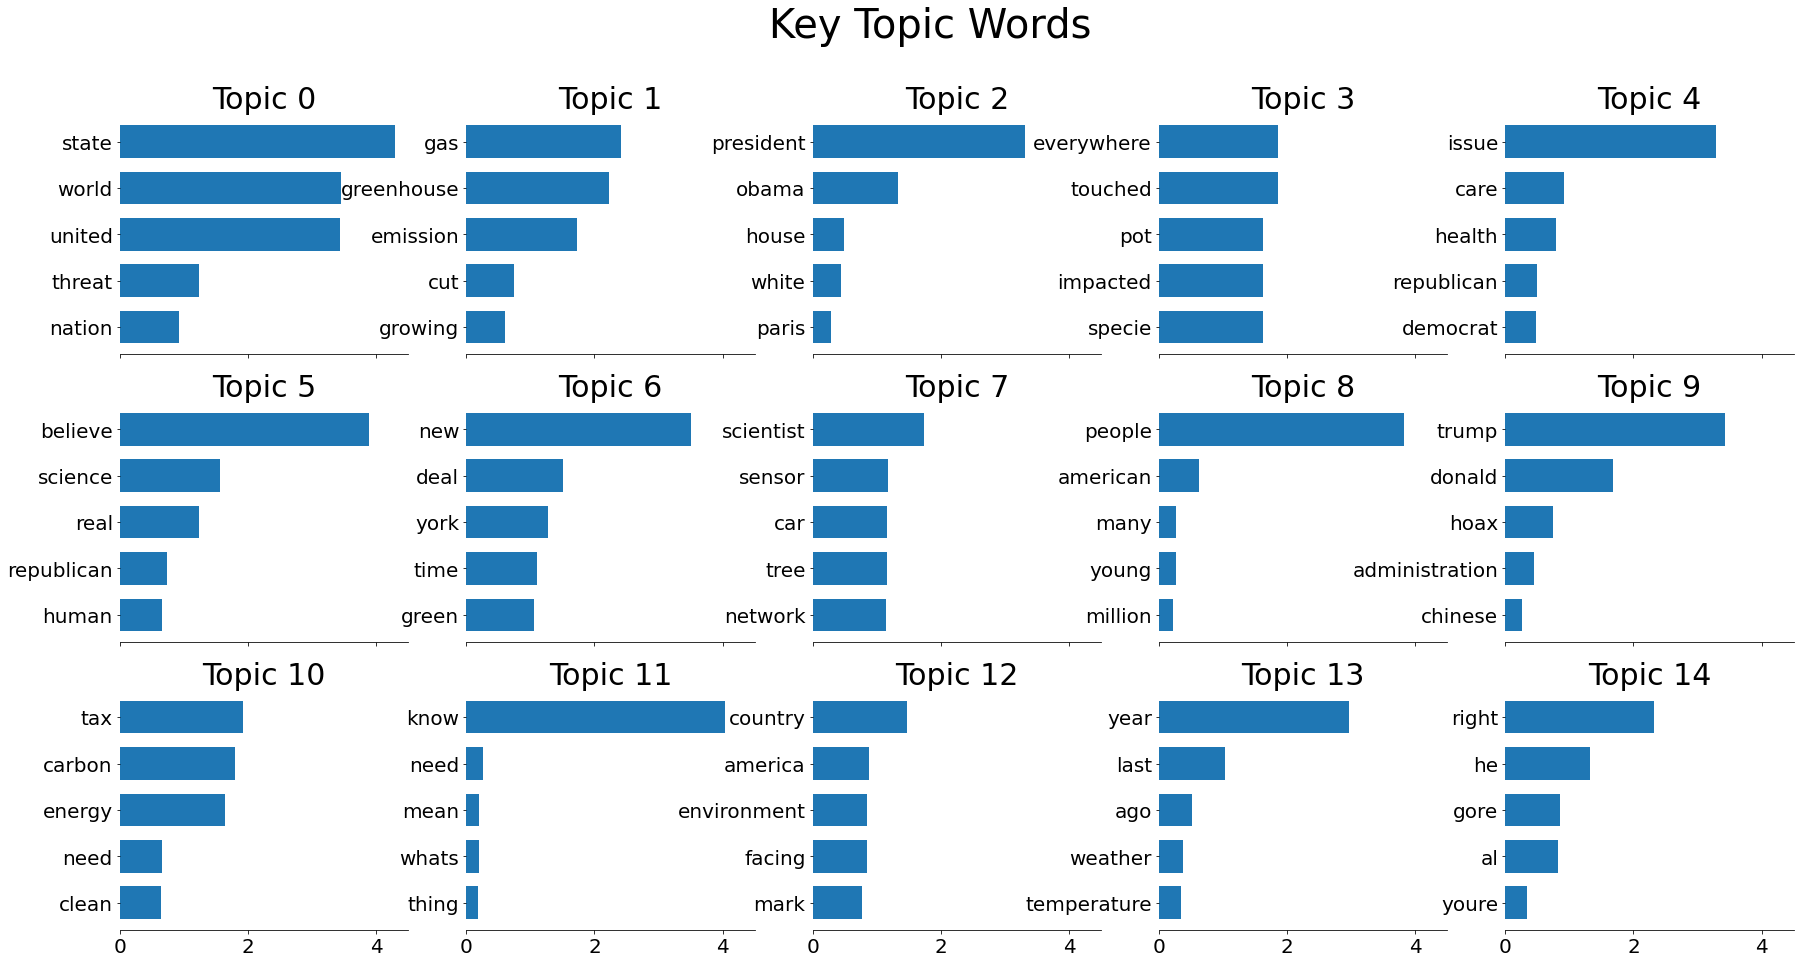

In [28]:
fig, ax = plot_top_words(nmf, feature_names)
fig.savefig("./plots/KeyTopicWords.png")
plt.show()

# 4) Monthly Analyses

We first count the number of times per month each topic is mentioned by each channel.  Frequency can be modified by resetting `freq` parameter.  Finer grained analysis (such as by show instead of by channel) can be added in as necessary.

In [102]:
def topic_mentions(snip, topic, model=nmf, names=tfidf_feature_names, no_top_words=5):
    relevant_words = topic_words(model, names, no_top_words)[topic]
    count = 0
    snippet = snip.split(" ")
    num = len(snippet)
    for word in relevant_words:
        count += snippet.count(word)
    return count / num
    

In [103]:
def get_topic_counts(cache, channel, idx, freq='M'):
    temp = channel.copy()
    temp.set_index("DateTime", inplace=True)
    temp = temp[["cleanSnip"]]
    temp = temp.groupby(pd.Grouper(freq=freq)).sum()
    temp = temp.loc[temp["cleanSnip"] != 0]
    for topic in range(NUM_TOPICS):
        temp[str(topic)] = temp["cleanSnip"].apply(lambda x:topic_mentions(x,topic))
    temp.drop("cleanSnip", axis=1, inplace=True)
    cache[idx] = temp

In [104]:
by_month = dict()
get_topic_counts(by_month, cnn, "cnn")
get_topic_counts(by_month, fox, "fox")
get_topic_counts(by_month, msnbc, "msnbc")

### Plotting

In [105]:
def plot_mentions_channel(channel, topics=range(NUM_TOPICS), save=True):
    fig, ax = plt.subplots()
    for k in topics:
        ax.plot(by_month[channel][str(k)], alpha=.6)

    ax.set_xlabel("Date")
    ax.set_ylabel("Topic Mentions")
    fig.suptitle("Topic Mentions by Month: " + channel.upper())
    if save:
        path = "./plots/topic_analysis/" + channel + "_Monthly_Mentions.png"
        fig.savefig(path)
    plt.show()

In [106]:
def plot_mentions_topic(topic, channels=CHANNELS, save=True):
    fig, ax = plt.subplots()
    for channel in channels:
        ax.plot(by_month[channel][str(topic)], alpha=.6, label=channel.upper())
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Topic Mentions")
    if save:
        path = "./plots/topic_analysis/" + str(topic) + "_Monthly_Mentions.png"
        fig.savefig(path)
    fig.suptitle("Mentions of Topic " + str(topic) + " by Month ")

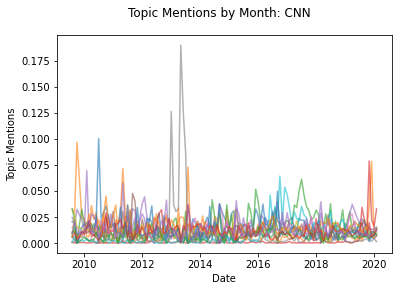

In [107]:
plot_mentions_channel("cnn")

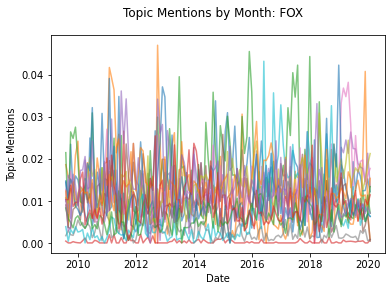

In [108]:
plot_mentions_channel("fox")

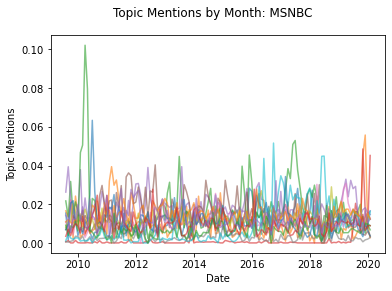

In [109]:
plot_mentions_channel("msnbc")

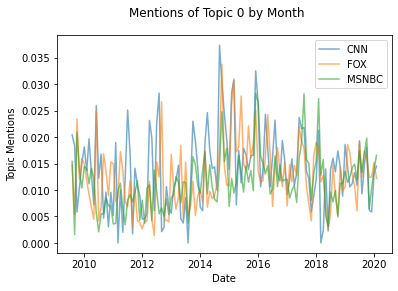

In [110]:
plot_mentions_topic(0)

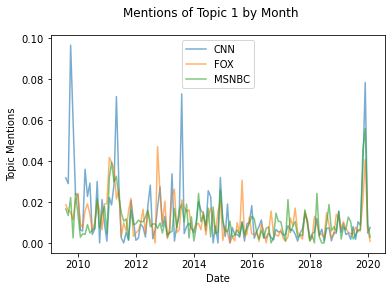

In [111]:
plot_mentions_topic(1)

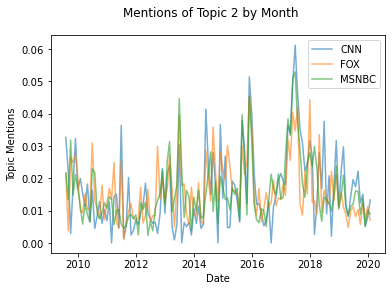

In [112]:
plot_mentions_topic(2)

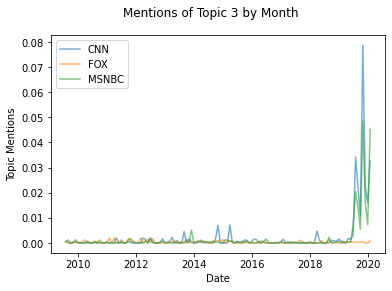

In [113]:
plot_mentions_topic(3)

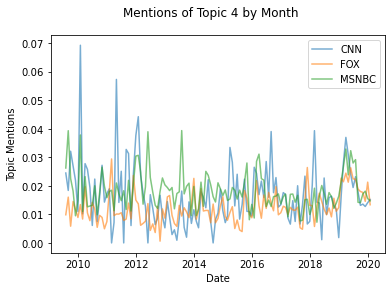

In [114]:
plot_mentions_topic(4)

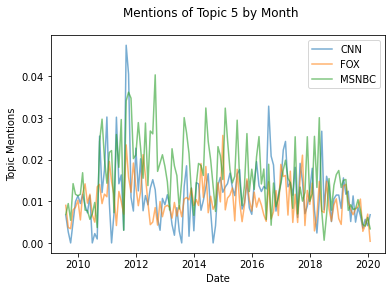

In [115]:
plot_mentions_topic(5)

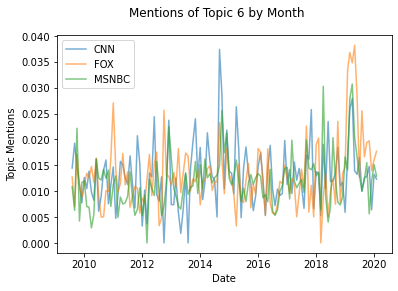

In [116]:
plot_mentions_topic(6)

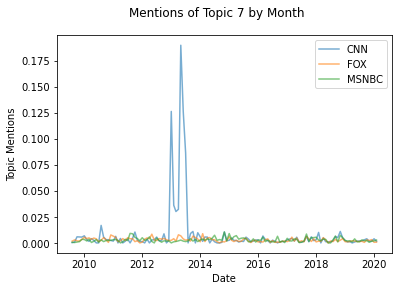

In [117]:
plot_mentions_topic(7)

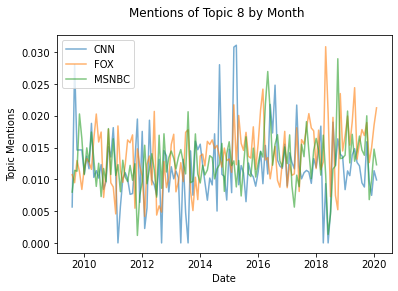

In [118]:
plot_mentions_topic(8)

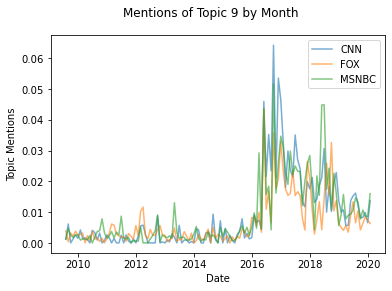

In [119]:
plot_mentions_topic(9)

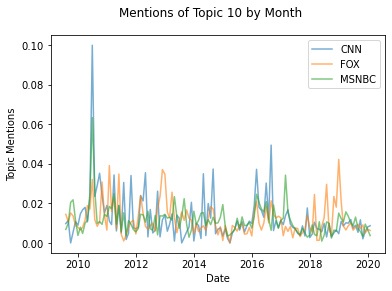

In [120]:
plot_mentions_topic(10)

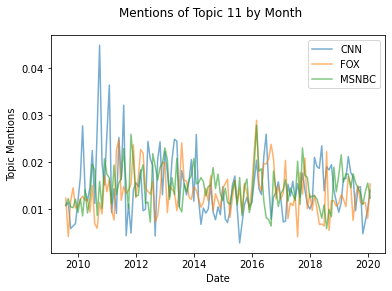

In [121]:
plot_mentions_topic(11)

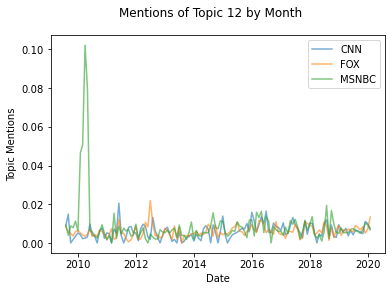

In [122]:
plot_mentions_topic(12)

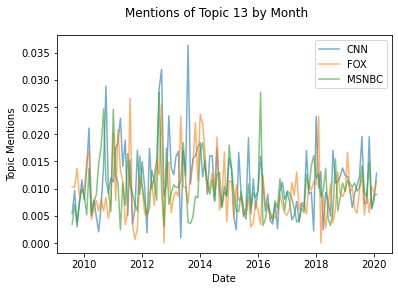

In [123]:
plot_mentions_topic(13)

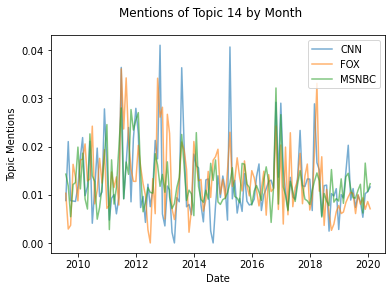

In [124]:
plot_mentions_topic(14)

# Hypothesis Testing

In [127]:
pres = dict()
posts = dict()
break_date = datetime.date(2017,1,31)
for channel in CHANNELS:
    pres[channel] = by_month[channel][:break_date]
    posts[channel] = by_month[channel][break_date:]

In [128]:
ts = dict()
pvals = dict()

tests = dict()

isequal=True
for channel in CHANNELS:
    ts[channel] = dict()
    pvals[channel] = dict()
    for topic in list(range(NUM_TOPICS)):
        test = ttest_ind(pres[channel][str(topic)], posts[channel][str(topic)], equal_var=isequal)
        
        pval = test.pvalue
        t = test.statistic
        ts[channel][str(topic)] = t
        pvals[channel][str(topic)] = pval
        tests[pval] = channel + "_" + str(topic)

In [131]:
ts = load("./models/t_statistics.joblib")
pvals = load("./models/pvalues.joblib")

In [132]:
all_ps = []
for channel in CHANNELS:
    temp = list(pvals[channel].values())
    all_ps += temp

In [133]:
adjusted = multipletests(all_ps, alpha=.05,method="holm")

In [134]:
adjusted

(array([False, False,  True,  True, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
        False,  True, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False,  True, False,  True,
        False, False, False,  True, False, False, False, False, False]),
 array([1.00000000e+00, 1.00000000e+00, 9.74419807e-03, 1.59074510e-02,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 3.57932071e-05, 2.01584097e-01, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        7.07264485e-01, 1.00000000e+00, 1.00000000e+00, 9.33354949e-03,
        1.00000000e+00, 6.89679768e-02, 7.07264485e-01, 1.33713501e-02,
        4.70474577e-05, 1.00000000e+00, 3.32072850e-01, 1.00000000e+00,
        1.00000000e+00, 2.75084088e-01, 8.80277836e-01, 1.00000000e+00,
        2.01584097e-01, 2.10063982e-02, 1.00000000e+00, 2.69633047e

In [135]:
print(break_date)

2017-01-31


In [177]:
doc = "Adjusted p-values for 2-sample T-test for change in mean between pre-Trump and post-Trump mentions \n"
doc += "(broken at " + str(break_date) + ")"
doc += "\n"
doc += "----------------------------------------------------------------------------------------------------\n"
counter = 1
for ind in range(len(all_ps)):
    if adjusted[0][ind]:
        pval_unadj = all_ps[ind]
        test = tests[pval_unadj]
        pval = adjusted[1][ind]
        channel = ""
        i = 0
        while i < len(test):
            char = test[i]
            if char.isalpha():
                channel += char
            else:
                break
            i += 1
        topic = test[i+1]
        display = f"{counter}) Channel: " + channel + ", Topic: " + topic + f", adjusted p-value: " + "{:.4f}".format(pval)
        doc += display + "\n"
        counter += 1

print(doc)

Adjusted p-values for 2-sample T-test for change in mean between pre-Trump and post-Trump mentions 
(broken at 2017-01-31)
----------------------------------------------------------------------------------------------------
1) Channel: cnn, Topic: 2, adjusted p-value: 0.0097
2) Channel: cnn, Topic: 3, adjusted p-value: 0.0159
3) Channel: cnn, Topic: 9, adjusted p-value: 0.0000
4) Channel: fox, Topic: 4, adjusted p-value: 0.0093
5) Channel: fox, Topic: 8, adjusted p-value: 0.0134
6) Channel: fox, Topic: 9, adjusted p-value: 0.0000
7) Channel: msnbc, Topic: 3, adjusted p-value: 0.0210
8) Channel: msnbc, Topic: 5, adjusted p-value: 0.0270
9) Channel: msnbc, Topic: 9, adjusted p-value: 0.0000



# Changepoint Detection

We run breakpoint detection with a constant model, using `ruptures`.

We first include some helper functions to analyze the results (note that the `ruptures.display` method has limited functionality):

In [137]:
def plot_breakpoints(channel, topic, n_bkps):
    data = by_month[channel][topic]
    bkps = break_points[channel][topic][n_bkps]
    COLORS = ["blue", "red"]
    alpha = .2
    fig, ax = plt.subplots()
    ax.plot(data)
    ax.set_xlabel("Date")
    ax.set_ylabel("Topic Frequency")
    start_date = data.index[0]
    bkps_ext = bkps
    for period in range(len(bkps_ext)):
        end_date = data.index[bkps_ext[period]-1]
        color = COLORS[period%2]
        ax.axvspan(start_date, end_date, facecolor=color, alpha=alpha)
        ax.text(end_date,0, str(end_date.date())[:7], rotation=90)
        start_date = end_date
    title = "Topic Frequency Change Points for Topic " + topic + " on " + channel.upper() 
    fig.suptitle(title)
    return fig, ax

In [138]:
def get_sum_of_cost(algo, n_bkps):

    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

In [139]:
bkps_range = list(range(1,11))

In [140]:
costs = dict()
algos = dict()
results = dict()
for channel in CHANNELS:
    costs[channel] = dict()
    algos[channel] = dict()
    results[channel] = dict()
    for topic in range(NUM_TOPICS):
        topic = str(topic)
        signal = by_month[channel][topic]
        algo = rpt.Dynp().fit(signal.to_numpy())
        algos[channel][topic] = algo
        results[channel][topic] = dict()
        for bks in bkps_range:
            results[channel][topic][str(bks)] = algo.predict(bks)
        costs[channel][topic] = [get_sum_of_cost(algo, bks) for bks in bkps_range]

In [142]:
costs = load("./models/CPD_costs.joblib")
break_points = load("./models/CPD_break_points.joblib")

In [182]:
def plot_channel_costs(channel):
    fig, ax = plt.subplots(3,5, figsize=(24,10))
    for topic in list(range(NUM_TOPICS)):
        i, j = topic // 5, topic % 5
        ax[i,j].plot(costs[channel][str(topic)])
        ax[i,j].set_title(f"Topic {topic}")
        #ax[i,j].set_xlabel("Number of Breakpoints")
        #ax[i,j].set_ylabel("Cost")
    
    title = "Channel " + channel.upper() + " Cost vs Number of Break Points"
    fig.suptitle(title)
    
    return fig, ax

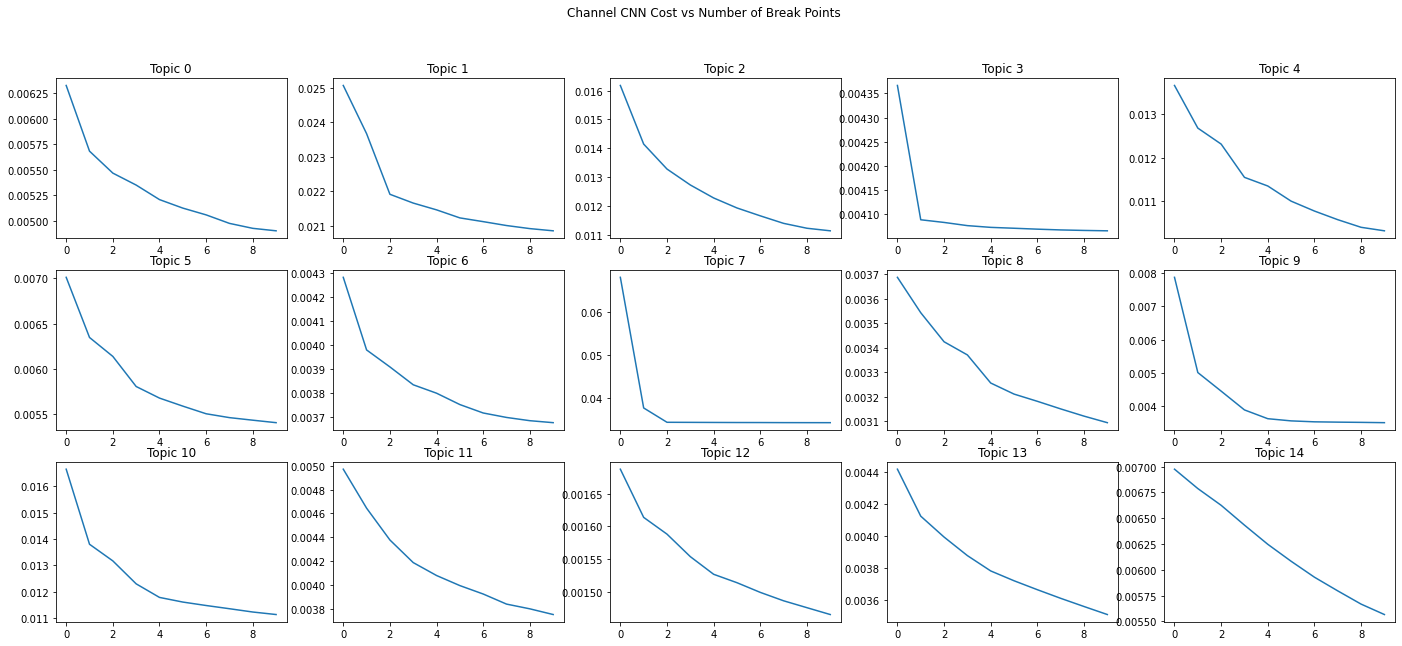

In [183]:
fig, ax = plot_channel_costs("cnn")
fig.savefig("./plots/ChangePointDetection/cnn_costs.png")
plt.show()

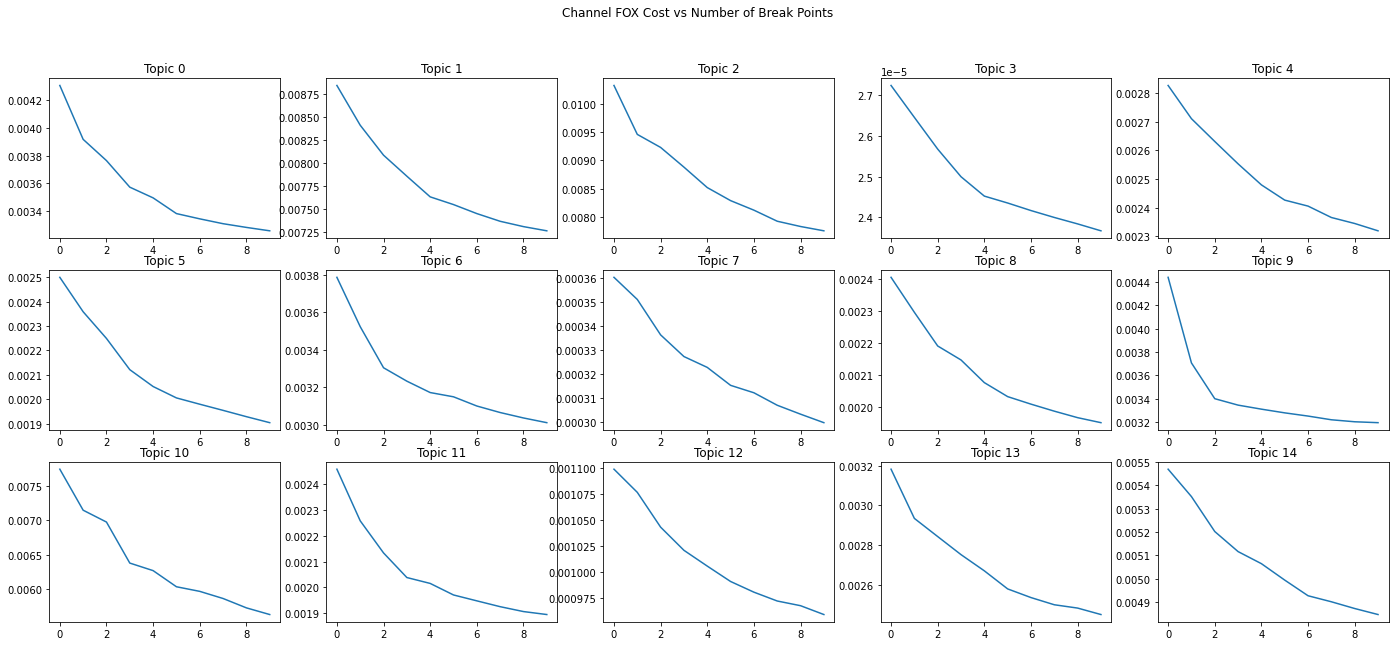

In [184]:
fig, ax = plot_channel_costs("fox")
fig.savefig("./plots/ChangePointDetection/fox_costs.png")
plt.show()

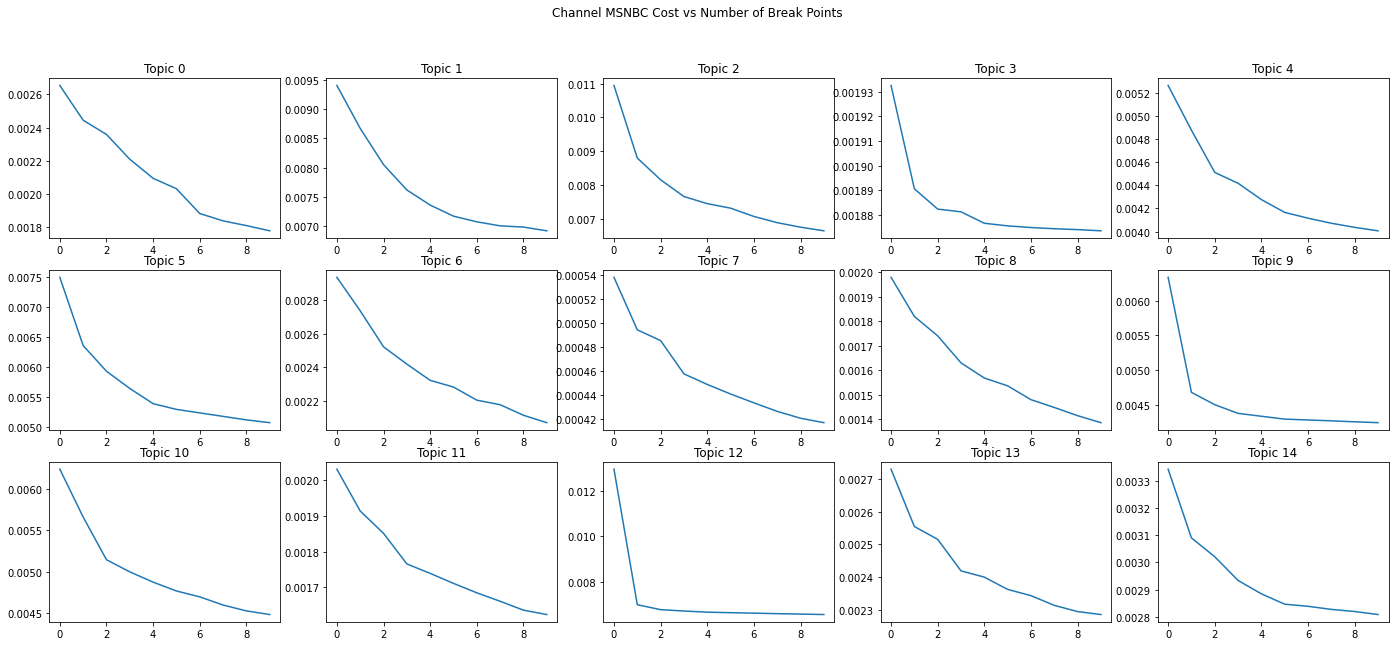

In [185]:
fig, ax = plot_channel_costs("msnbc")
fig.savefig("./plots/ChangePointDetection/msnbc_costs.png")
plt.show()

We now find the important changepoints for the most obviously political of the topics: topic 3

In [150]:
def breakpoints(channel, topic, n, save=True):
    fname = "./plots/ChangePointDetection/" + channel + "_topic" + topic +".png"
    fig, ax = plot_breakpoints(channel, topic, str(n))
    if save:
        fig.savefig(fname)
    return fig, ax
#     plt.show()

<ipython-input-137-203ce0d63764>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


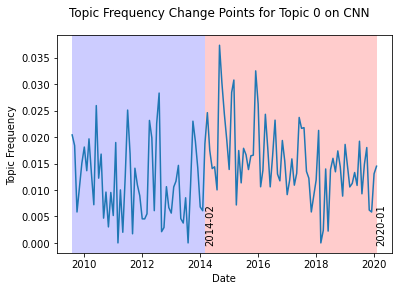

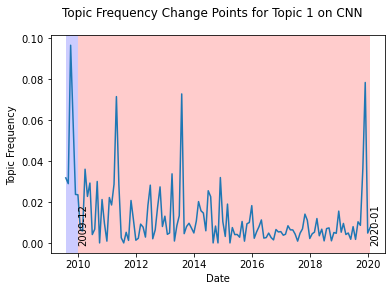

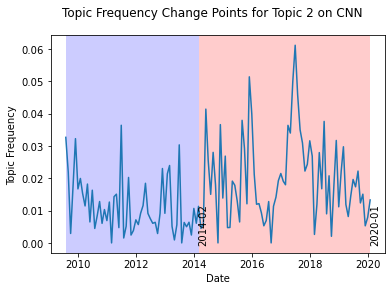

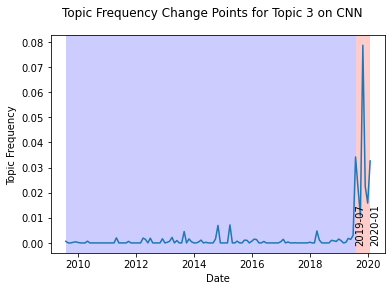

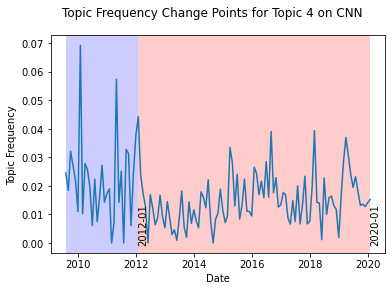

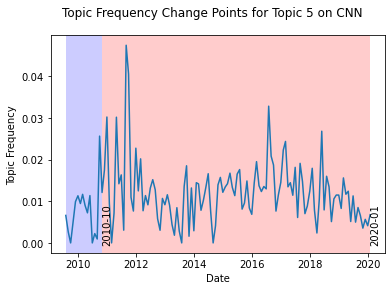

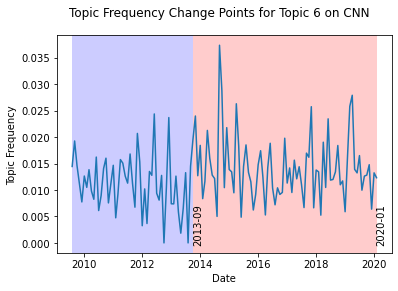

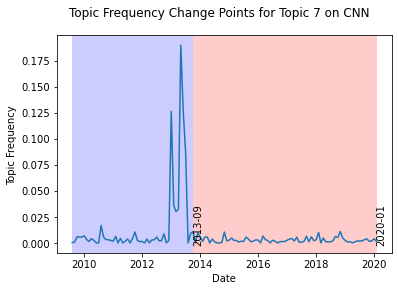

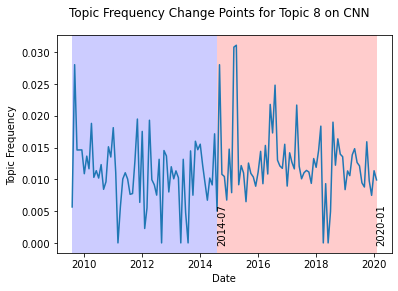

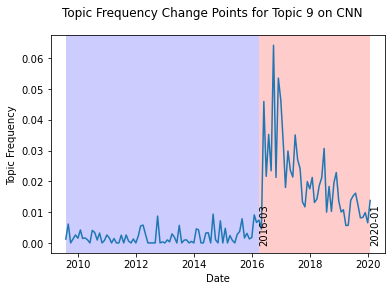

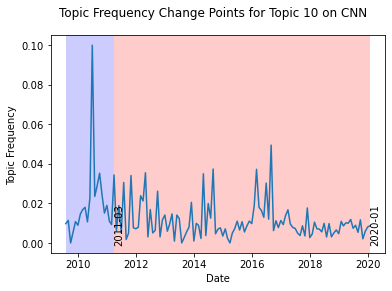

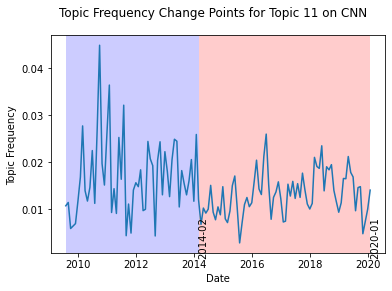

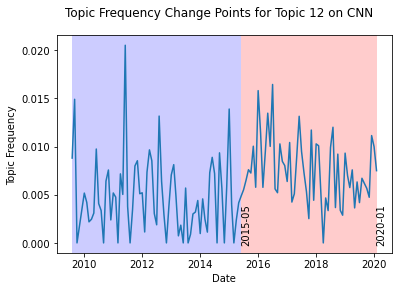

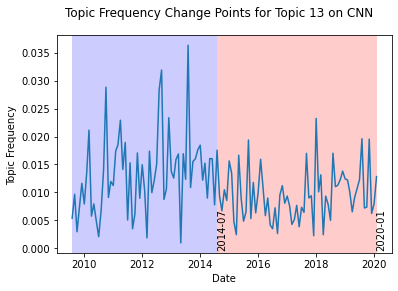

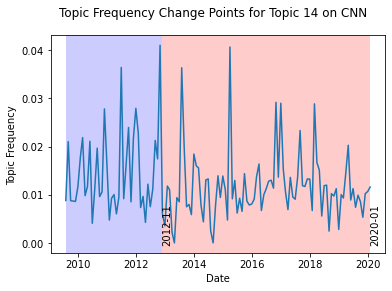

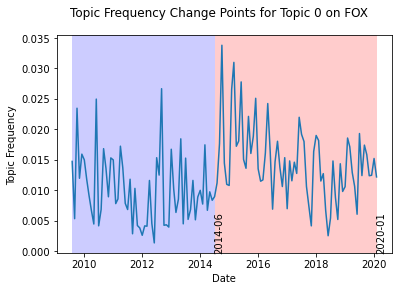

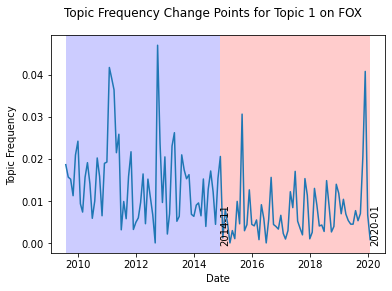

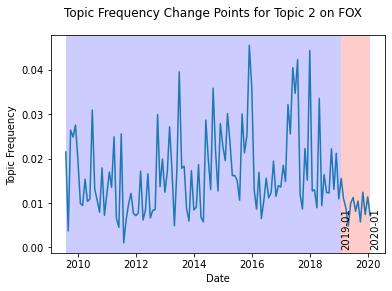

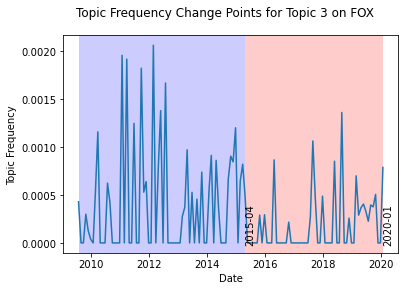

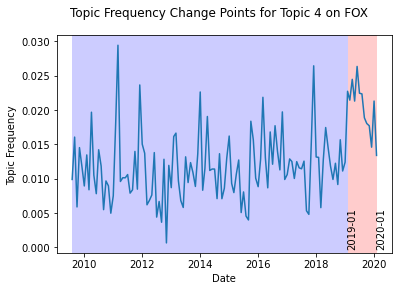

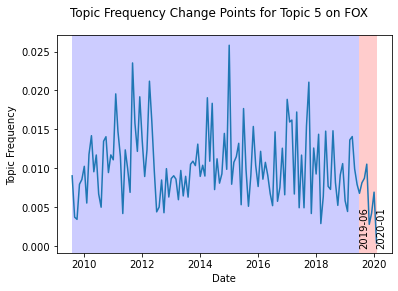

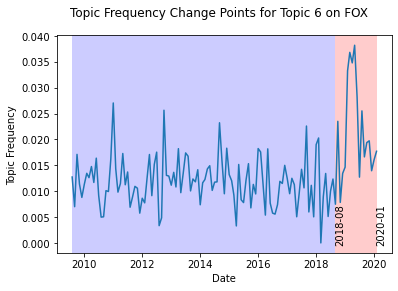

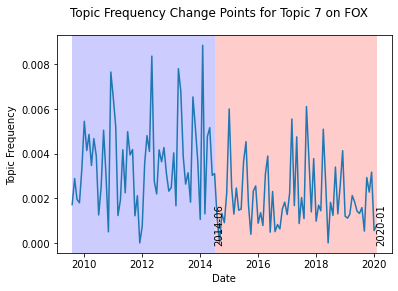

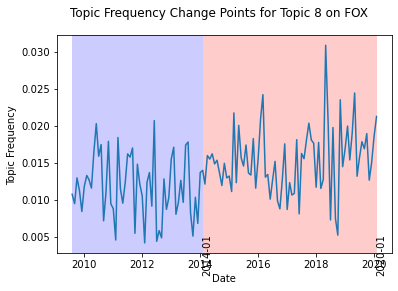

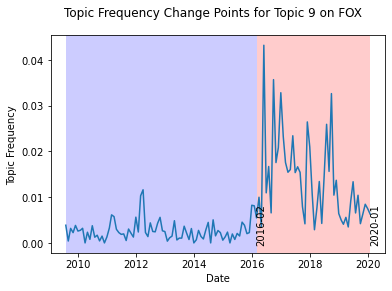

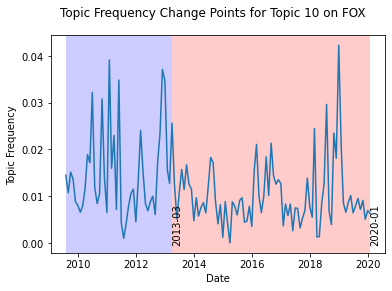

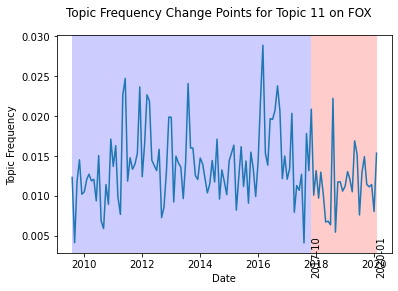

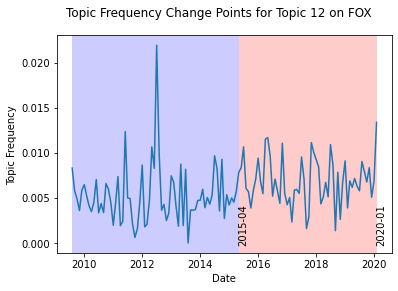

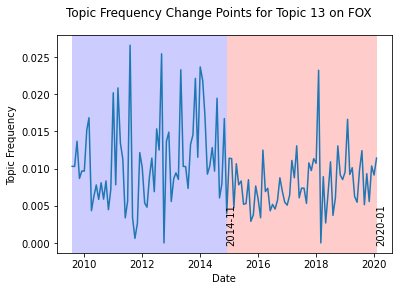

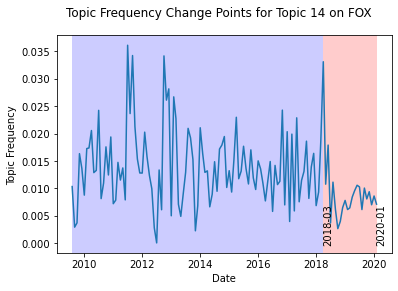

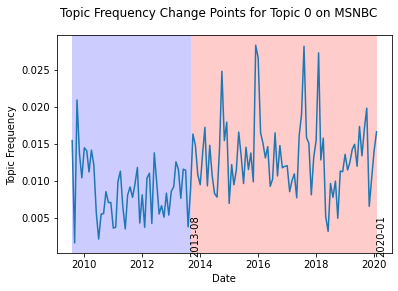

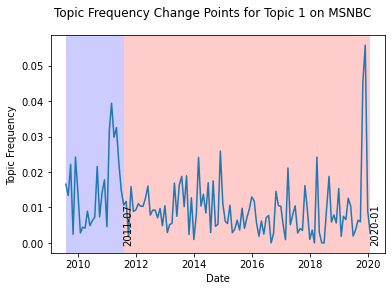

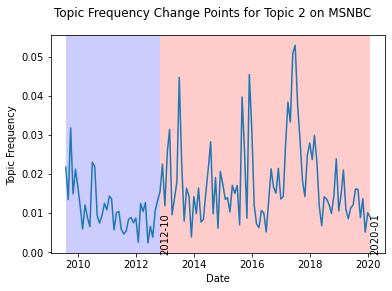

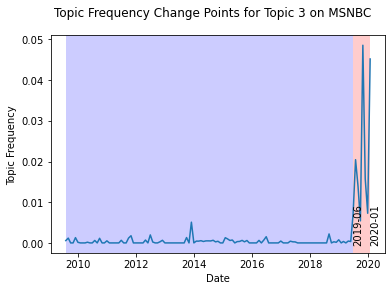

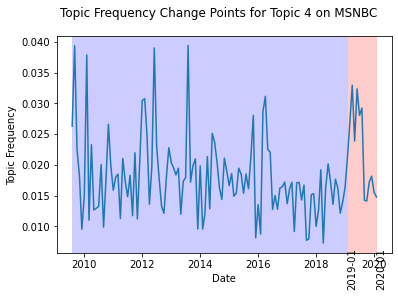

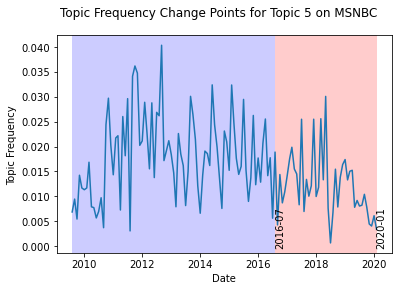

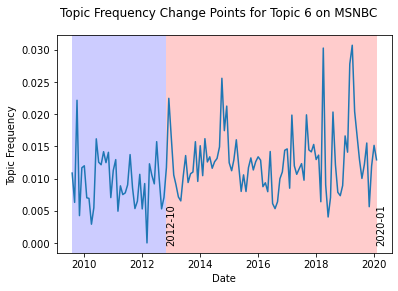

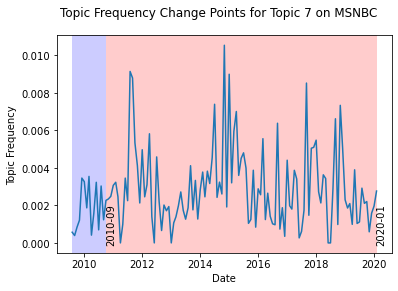

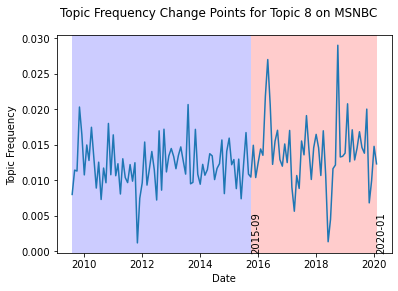

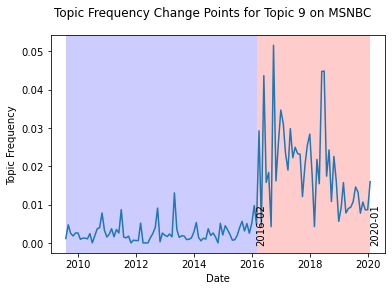

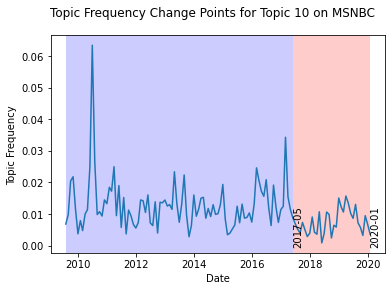

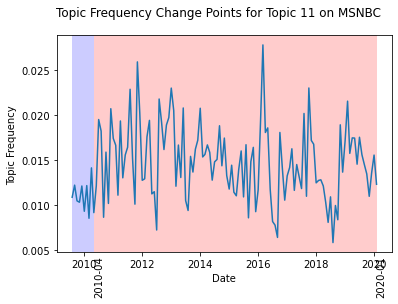

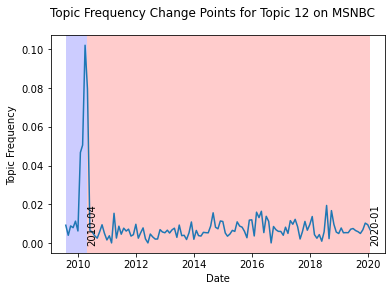

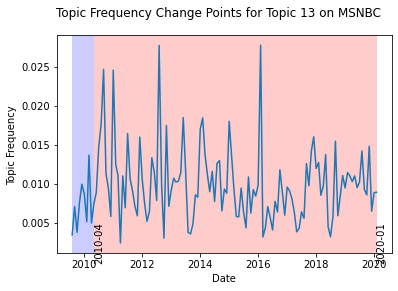

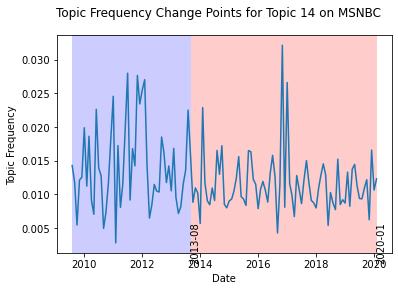

In [165]:
break_points_plots = dict()
for channel in CHANNELS:
    break_points_plots[channel] = dict()
    for topic in range(NUM_TOPICS):
        break_points_plots[channel][topic] = breakpoints(channel, str(topic), 1)